# Analisi e simulazione dei consumi energetici dell'anello di teleriscaldamento
 

In [2]:
import pandas as pd 
import datetime 
import seaborn as sns 
import matplotlib.pyplot as plt
import random
import numpy as np
from sklearn.linear_model import LinearRegression

# 1. Analisi dati climatici

## Caricamento dei dati

### Caricamento dati da CLOE Energyteams

In [3]:
data = pd.read_csv("data\Te_riscPad_31122022071231.csv",
                 sep = ";",
                 skiprows = 2,
                 usecols=["day","time", "(D)Energia Termica Edificio D", "Temperatura Ambiente"])

data.columns = ["day", "time", "temp", "energy"]
data['day_time'] = pd.to_datetime(data['day'] + data['time'], format='%d-%m-%Y%H:%M:%S')
data['energy'] = data.energy/1000
data

,day,time,temp,energy,day_time
0,01-01-2018,00:00:00,0.00,0.0,2018-01-01 00:00:00
1,01-01-2018,01:00:00,0.00,0.0,2018-01-01 01:00:00
2,01-01-2018,02:00:00,0.00,0.0,2018-01-01 02:00:00
3,01-01-2018,03:00:00,0.00,0.0,2018-01-01 03:00:00
4,01-01-2018,04:00:00,0.00,0.0,2018-01-01 04:00:00
...,...,...,...,...,...
43795,30-12-2022,19:00:00,10.82,2.0,2022-12-30 19:00:00
43796,30-12-2022,20:00:00,10.82,0.0,2022-12-30 20:00:00
43797,30-12-2022,21:00:00,10.82,7.5,2022-12-30 21:00:00
43798,30-12-2022,22:00:00,10.82,52.0,2022-12-30 22:00:00


<AxesSubplot:>

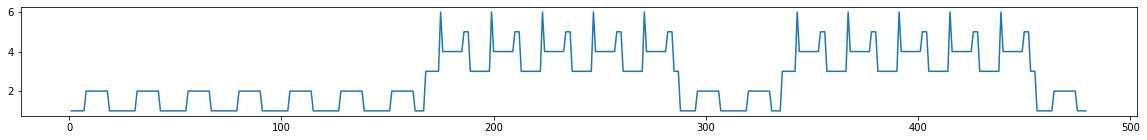

In [320]:
# crea nuove colonne anno, mese, giorno, giorno della settimana e dell'anno
def add_date_time_columns(df):
    df['year'] =  df.day_time.dt.year
    df['month'] = df.day_time.dt.month 
    df['dd'] =    df.day_time.dt.day 
    df['dw'] =    df.day_time.dt.day_of_week +1
    df['dy'] =    df.day_time.dt.day_of_year
    df['hh'] =    df.day_time.dt.hour
    df['date_id'] = (df.year.astype(str) + df.month.astype(str).str.zfill(2) + df.dd.astype(str).str.zfill(2)).astype(int)
    return df

def set_holiday(df):
    df['holiday'] = False
    df.loc[ (df.month == 1 ) &  df.dd.isin( (1,2,3,4,5,6)) , "holiday"   ] = True
    df.loc[ (df.month == 11) &  df.dd.isin( (2,3,4)) , "holiday"         ] = True
    df.loc[ (df.month == 12) &  df.dd.isin( (24,25,26)) , "holiday"   ] = True
    return df
 
def set_operating_mode(df):
    
    w_hours =    (df.hh > 7 )           & (df.hh <=18 )
    peak_start = (df.hh.isin((7,7))      )
    peak_stop  = (df.hh.isin((18,19,20)) )
    w_days  =    (df.dw <= 5 )          & (-df.holiday) 
   
    df['op_mode'] = 0   # spento
    df.loc[ (-w_days & -w_hours   ), "op_mode"] = 1 # notte feriale
    df.loc[ (-w_days &  w_hours   ), "op_mode"] = 2 # giorno feriale
    df.loc[ ( w_days & -w_hours   ), "op_mode"] = 3 # notte lavorativo
    df.loc[ ( w_days &  w_hours   ), "op_mode"] = 4 # giorno lavorativo
    df.loc[ ( w_days &  peak_stop ), "op_mode"] = 5 # picco spegnimento lavorativo
    df.loc[ ( w_days &  peak_start), "op_mode"] = 6 # picco accensione lavorativo

    # color_op_modes = ("black","purple", "blue", "red", "red", "red")
    # desc_op_modes = ("notte feriale","giorno feriale", "notte lavorativo", "giorno lavorativo", "picco spegnimento lavorativo", "picco accensione lavorativo")
    
    
    return df



data = add_date_time_columns(data)
data = set_holiday(data)
data = set_operating_mode(data)
plt.figure(figsize = (20,2))
data.op_mode[1:(24*20)].plot()

## Simulazione delle temperature

4392
4392


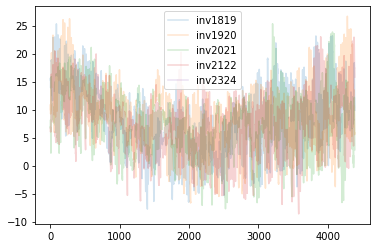

In [273]:
data['stagione'] = "-"
anni = [2018,2019,2020,2021,2022,2023]
stagioni = ["inv1819" ,"inv1920" ,"inv2021" ,"inv2122", "inv2223","inv2324"]

tempinv = pd.DataFrame( columns = stagioni ) 
nn = 183*24
print(nn)
nulls = list(["NaN"]*nn) 

for i in range(0,5):
    data.loc[ (data.year == anni[i])   & (data.dy >= 288) , "stagione"] = stagioni[i]  
    data.loc[ (data.year == anni[i]+1) & (data.dy <= 108) , "stagione"] = stagioni[i]
    x =  data.loc[ data.stagione == stagioni[i] ].temp.head(nn).to_list()
    x = x + nulls
    tempinv[ stagioni[i] ] = x[0:nn]

tempinv.reset_index(inplace=True)
tempinv['week'] = (tempinv['index'] // (7*24))+1
tempinv.drop(columns=["index"], inplace=True)  
tempinv[stagioni].plot(alpha = .2)
nsim = 200
cols = ["sim"+ str(i) for i in range(1,nsim+1)]

tempinv_sim = pd.DataFrame(columns = cols)
 
for s in range(0,nsim):
    x = []
    for w in range(1,28):
        weeklytemp = tempinv[ tempinv.week == w] 
        i = random.randint(0,3)
        x = x + weeklytemp[ stagioni[ i ] ].to_list()
    tempinv_sim[cols[s]] = x
         
tempinv.to_csv("temperature_misurate.csv")
tempinv_sim.to_csv("temperature_simulate.csv")
print(len(tempinv_sim))


## Simulazione della regolazione dell'impianto

Definizione del lavorativoime di funzionamento
iniziamo con una suddivisione in due gruppi: 
- attivo a 20°C nominali
- attenuazione notturna e festiva

<AxesSubplot:>

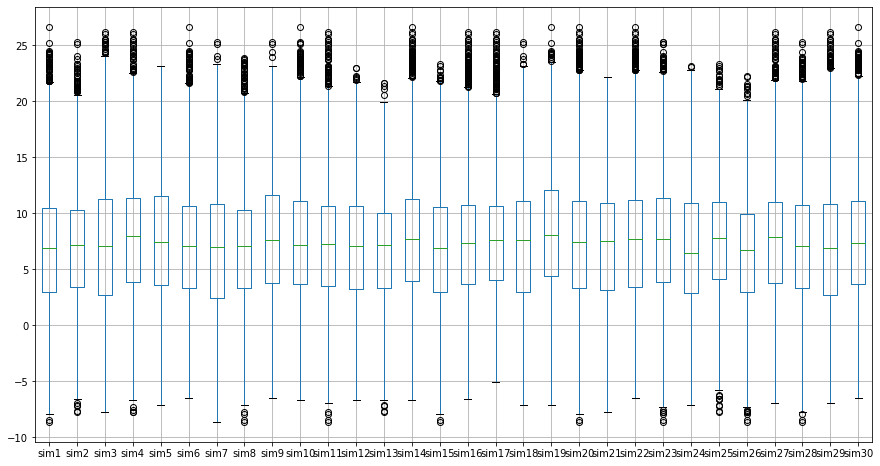

In [94]:
tempinv_sim[cols[0:30]].boxplot(figsize=(15,8))

<AxesSubplot:>

<Figure size 432x288 with 0 Axes>

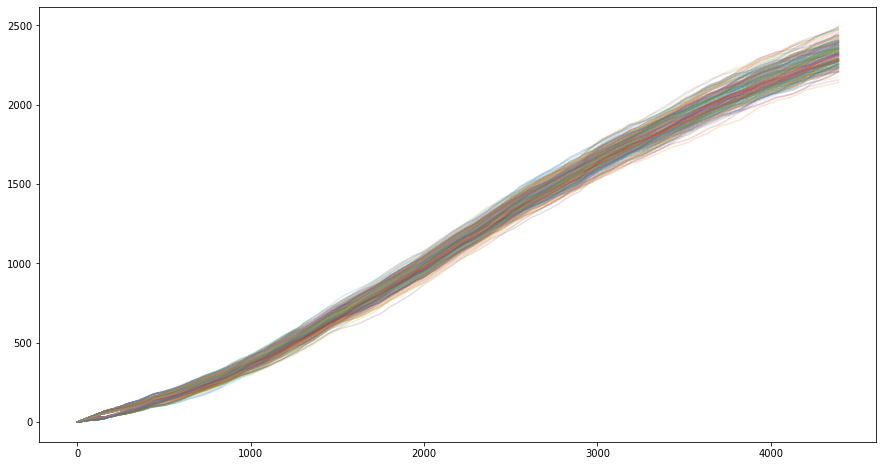

In [95]:
#gg simulati
sim_gg = pd.DataFrame(columns = cols)

for c in cols: 
    te = tempinv_sim[c].copy()
    te[ te > 20 ] = 20
    dt = 20 - te
    sim_gg[c] = dt.cumsum() / 24

plt.figure()  
sim_gg.plot(legend = False, figsize=(15,8), alpha = .2)

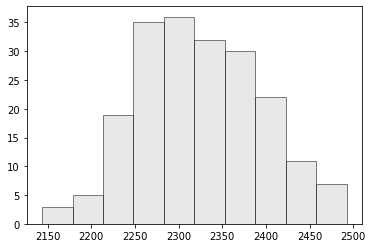

In [96]:
gg_simulati_inizio = sim_gg.tail(1).values.tolist()[0]
plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = 0.5 )
plt.show()

In [97]:
# intrvallo di confidenza
gg_simulati_inizio.sort() 
xs = [round(x) for x in gg_simulati_inizio] 
print("minimo", xs[0] , " -  massimo", xs[99], "gradi giorno")
print("mediana: ", xs[50] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[94], "gradi giorno")

minimo 2144  -  massimo 2320 gradi giorno
mediana:  2276 gradi giorno
intervallo di confidenza al 90%:  2208  -  2317 gradi giorno


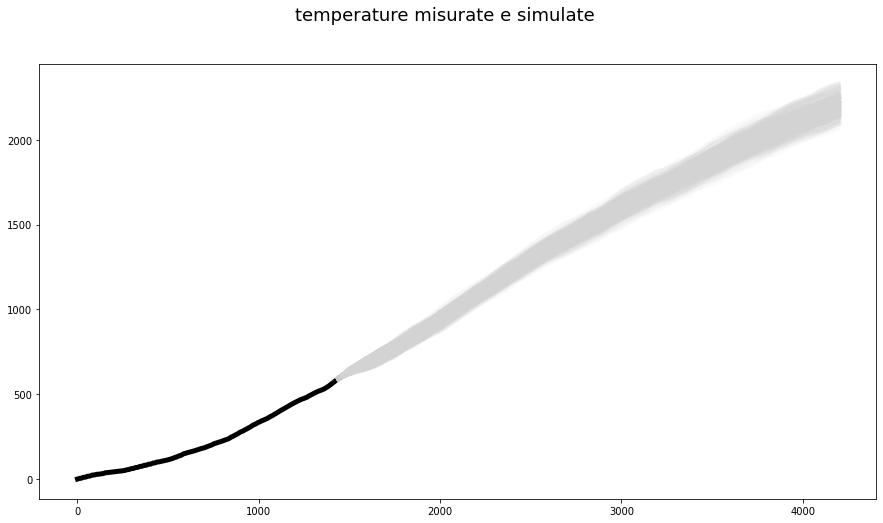

In [98]:
# serie composta da una parte misurata e una stimata
sim_gg_misti = pd.DataFrame(columns = cols)

limite =60*24
temp_misurate = tempinv["inv2223"]
temp_misurate = temp_misurate[0:limite].values
temp_misurate = [float(i) for i in temp_misurate]

for c in cols: 
    temp_simulate = tempinv_sim[c][limite+1:4199].values 
    temp_simulate = [float(i) for i in temp_simulate]
    te =  [  *temp_misurate , *temp_simulate ]
    te = [x if x < 20 else 20 for x in te]
    dt = [20 - x for x in te]
    sim_gg_misti[c] = pd.Series(dt).cumsum() / 24





plt.figure( figsize=(15,8))  
plt.plot(sim_gg_misti[0:limite].sim1,  alpha = 1, color = "black", linewidth=5)
plt.plot(sim_gg_misti[limite:4199],  alpha = .1, color = "lightgray", linewidth=5)
plt.suptitle('temperature misurate e simulate', fontsize=18)
plt.show()

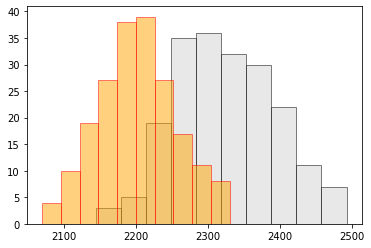

In [99]:

gg_simulati_dic = sim_gg_misti.tail(1).values.tolist()[0]

plt.hist(gg_simulati_inizio, color = "lightgray", edgecolor = "black", alpha = .5 , bins = 10 )
plt.hist(gg_simulati_dic, color = "orange", edgecolor = "red", alpha = 0.5, bins = 10 )
plt.show()

In [100]:
# intrvallo di confidenza
gg_simulati_dic.sort() 
xs = [round(x) for x in gg_simulati_dic] 
  
print("minimo", xs[0] , " -  massimo", xs[nsim-1], "gradi giorno")
print("mediana: ", xs[nsim//2] , "gradi giorno")
print("intervallo di confidenza al 90%: ", xs[5]," - " , xs[nsim-5], "gradi giorno")

minimo 2070  -  massimo 2330 gradi giorno
mediana:  2203 gradi giorno
intervallo di confidenza al 90%:  2097  -  2318 gradi giorno


## Simulazione dei consumi energetici

### esplorazione: scatter plot temperature / consumi 

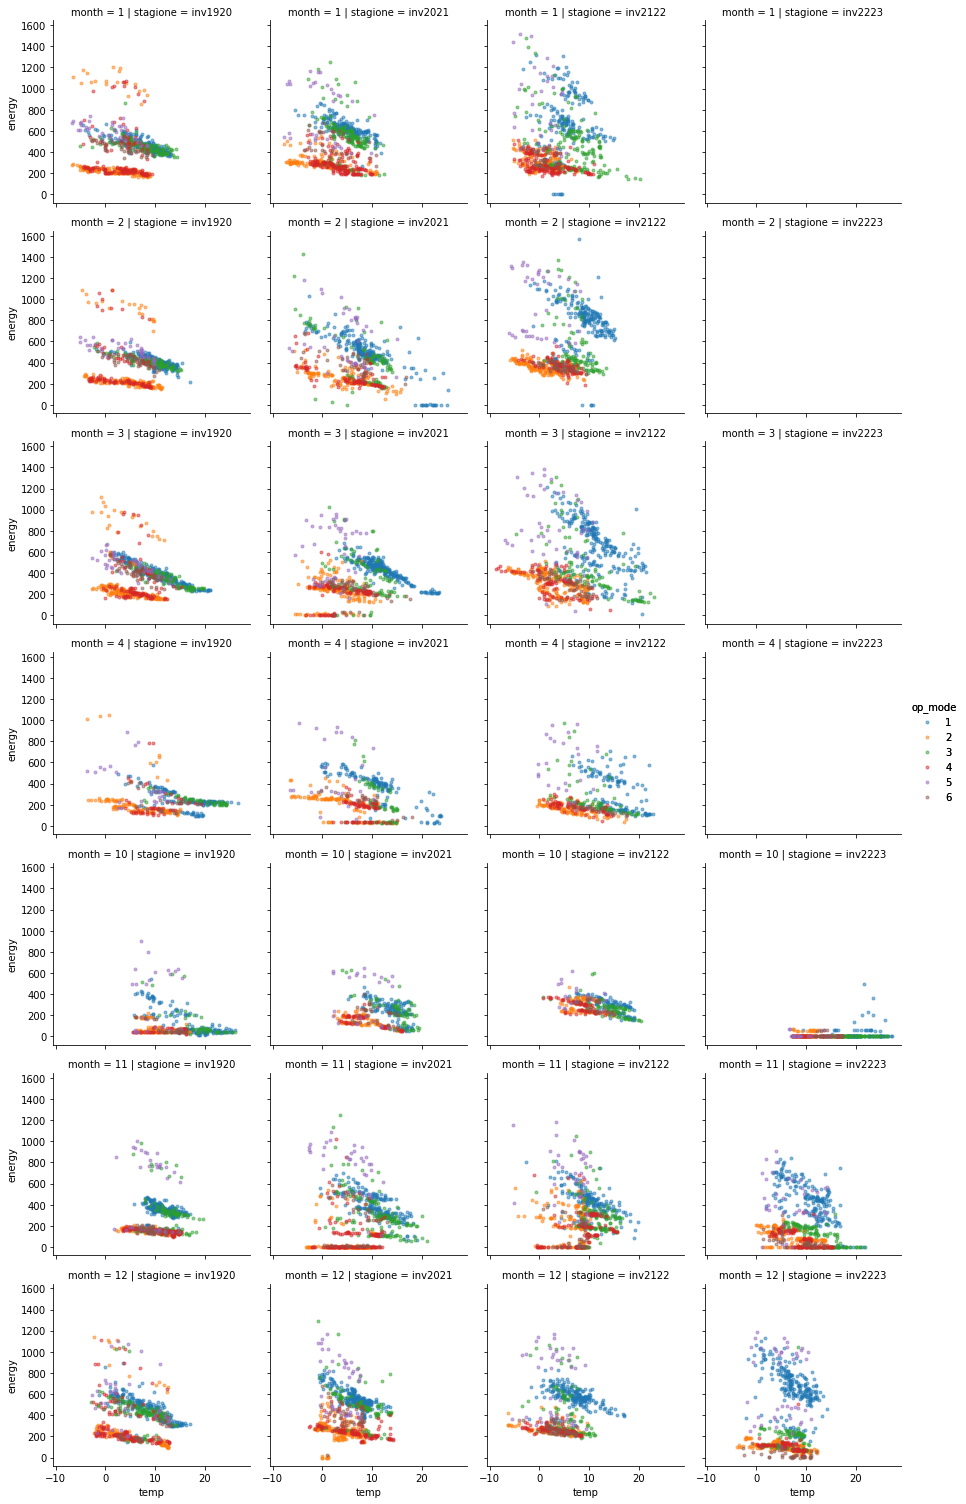

In [101]:
dplot = data[ data.stagione != "-" ]
dplot = dplot[ dplot.stagione != "inv1819" ]
dplot = dplot[["temp", "energy","stagione", "year", "month","op_mode"]]
g = sns.FacetGrid(dplot, col="stagione",  row="month", hue='op_mode').add_legend()
g = g.map(plt.scatter, "temp", "energy", alpha = 0.5, marker = ".").add_legend()
plt.show()

## Preparazione dati: selezione del dataset per la regressione lineare

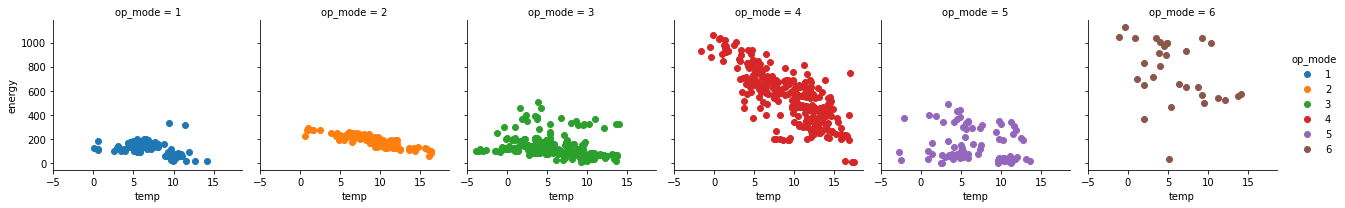

In [321]:
data_learn = data[ data.stagione == "inv2223" ]

# energy non negativa
data_learn = data_learn[ data_learn.energy > 1.0 ] 

# escludiamo periodi di spegnimento e test
gg_validi_nov = (data_learn.month == 11) & (data_learn.dd >=  7)  
gg_validi_dic = (data_learn.month == 12) & (data_learn.dd <= 16)  # dal 17 dic regime ulteriormente attenuato
data_learn = data_learn[ gg_validi_nov | gg_validi_dic ]
g = sns.FacetGrid(data_learn,  col = "op_mode",  hue = "op_mode")
g = g.map(plt.scatter, "temp", "energy").add_legend()

## Pulizia dati
in questo modo fatta su tutti i dati, 
meglio sarebbe farla sulle 4 parti diurno / lavorativo

Pulizia per ciascuno dei regimi di funzionamento

In [250]:
from sklearn.cluster import DBSCAN
def identifica_outliers(Z, epsilon, minpoints, echo = False):
    
    #normalize by column
    Zn = (Z - Z.mean(axis = 0)) / Z.std(axis = 0)
    
    #identify clusters and "halo"
    clustering = DBSCAN(eps=epsilon, min_samples=minpoints).fit(Zn)
    is_halo = clustering.labels_ <  0
    
    Zh = Z[ is_halo] # points belong to HALO
    Zc = Z[~is_halo] # points belong to some cluster
    
    print("Punti identificati come halo: ", round(is_halo.mean()*100,1),"%")
    if echo:
        
        plt.figure(figsize= (5,5))
        plt.scatter(Zh[:,0], Zh[:,1], color = "gray", alpha = .2)
        plt.scatter(Zc[:,0], Zc[:,1], c = clustering.labels_[~is_halo],alpha = 1)
        plt.show()
        
    
       
    return(is_halo)

regime di funzionamento 1
Punti identificati come halo:  3.8 %
125
regime di funzionamento 2
Punti identificati come halo:  1.8 %
233
regime di funzionamento 3
Punti identificati come halo:  3.5 %
508
regime di funzionamento 4
Punti identificati come halo:  1.3 %
802
regime di funzionamento 5
Punti identificati come halo:  4.7 %
883
regime di funzionamento 6
Punti identificati come halo:  30.0 %
904
904
Modello senza outlier


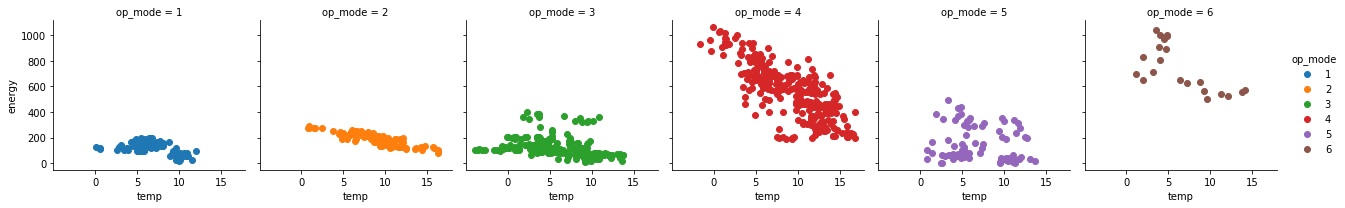

In [322]:
data_learn_clean = data_learn.head(0)
for i in range(1,7):
    print("regime di funzionamento", i)
    data_regime_i = data_learn.loc[ data_learn.op_mode == i ]
    zz = data_regime_i.loc[ : , ['temp', 'energy']].values
    outlier = identifica_outliers(zz, epsilon = 0.60, minpoints=4, echo = False)
    data_learn_clean = data_learn_clean.append(data_regime_i[ ~ outlier ])
    print(len(data_learn_clean))

print(len(data_learn_clean))
    
print("Modello senza outlier")
g = sns.FacetGrid(data_learn_clean,  col = "op_mode",  hue = "op_mode") #row = "month",
g = g.map(plt.scatter, "temp", "energy").add_legend()

data_learn_clean.to_csv('data_learn.csv')

### modello regressione lineare 
dataset di apprendimento: dal 1 novembre al 20 dicembre 2022

# modello

definiamo i dati da cui ricavare i modelli, con 4 regimi di funzionamento

rimuozione outliers

identifica gli outliers dei 4 gruppi
NB il diurno festivo ha due regimi diversi perchè è stata modificata la regolazione  tra novembre e dicembre

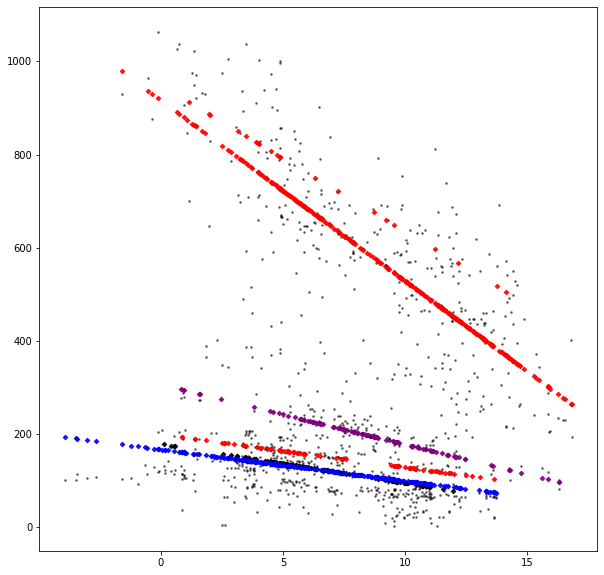

In [323]:
from sklearn.linear_model import LinearRegression

indice =  range(1,7)
modello = pd.DataFrame(index = indice)
modello['coeff'] = 0
modello['inter'] = 0
modello['score'] = 0

color_op_modes = ("black","purple", "blue", "red", "red", "red")
desc_op_modes = ("notte feriale","giorno feriale", "notte lavorativo", "giorno lavorativo", "picco spegnimento lavorativo", "picco accensione lavorativo")
    
modello['colors'] = color_op_modes  
modello['desc'] =   desc_op_modes
plt.figure(figsize = (10,10)) 

for i in indice:
    
    data_i = data_learn_clean[ data_learn_clean.op_mode == i].loc[ :, ['temp', 'energy']].values

    X = data_i[:,0].reshape(-1, 1)
    y = data_i[:,1]
      
    model = LinearRegression()
    model.fit(X, y)
    
    modello.loc[i, 'score'] = model.score(X, y).round(4)*100
    modello.loc[i, 'coeff'] = round(model.coef_[0],3)
    modello.loc[i, 'inter'] = round(model.intercept_,3)
     
    y_sim = X * modello.loc[i].coeff + modello.loc[i].inter
    
    
    plt.scatter( x = X, y = y, c="black",  marker = ".", s = 10,alpha = 0.5,)
    plt.scatter( x = X, y = y_sim, c=modello['colors'][i], marker = "D", s = 10,alpha = 0.9,)
    #plt.show()
     


   

In [324]:
modello

,coeff,inter,score,colors,desc
1,-8.411,178.193,27.29,black,notte feriale
2,-12.817,305.504,75.31,purple,giorno feriale
3,-6.768,166.277,13.07,blue,notte lavorativo
4,-38.841,916.655,59.46,red,giorno lavorativo
5,-7.064,198.660,3.33,red,picco spegnimento lavorativo
6,-31.394,949.170,44.18,red,picco accensione lavorativo


# Validazione
confrontare i dati simulati e misurati sulla stagione 22 23

# previsione
applicare il modello al resto della stagione
pervedere consumi e costi

### simulazione prezzi

In [325]:
prezzo_min = 0.20
prezzo_med = 0.30
prezzo_max = 0.40

### Simulazione date

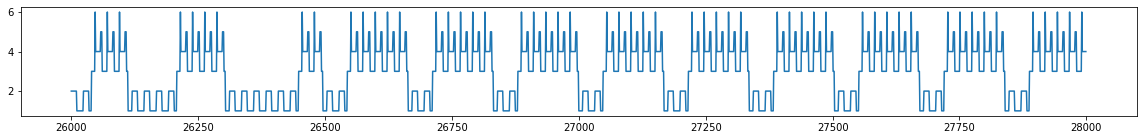

In [326]:
# input: anno di simulazione
sim_start_year = 2022
sim_start =  pd.to_datetime("15-10-" + str(sim_start_year))
sim_end   =  pd.to_datetime("16-04-" + str(sim_start_year+1))
sim_cal = pd.DataFrame({"day_time": pd.date_range(sim_start, sim_end,  freq ='1H')}).head(4368)
sim_cal['day'] =  sim_cal.day_time.dt.day

sim_cal = add_date_time_columns(sim_cal)
sim_cal = set_holiday(sim_cal)
sim_cal = set_operating_mode(sim_cal)
plt.figure(figsize = (20,2))
data.op_mode[26000:28000].plot()



sim_cal.to_csv("sim_cal.csv")

In [327]:
sim_cal

,day_time,day,year,month,dd,dw,dy,hh,date_id,holiday,op_mode
0,2022-10-15 00:00:00,15,2022,10,15,6,288,0,20221015,False,1
1,2022-10-15 01:00:00,15,2022,10,15,6,288,1,20221015,False,1
2,2022-10-15 02:00:00,15,2022,10,15,6,288,2,20221015,False,1
3,2022-10-15 03:00:00,15,2022,10,15,6,288,3,20221015,False,1
4,2022-10-15 04:00:00,15,2022,10,15,6,288,4,20221015,False,1
...,...,...,...,...,...,...,...,...,...,...,...
4363,2023-04-14 19:00:00,14,2023,4,14,5,104,19,20230414,False,5
4364,2023-04-14 20:00:00,14,2023,4,14,5,104,20,20230414,False,5
4365,2023-04-14 21:00:00,14,2023,4,14,5,104,21,20230414,False,3
4366,2023-04-14 22:00:00,14,2023,4,14,5,104,22,20230414,False,3


### simulazione fabbisogno energetico


In [328]:
sim_cal.columns

Index(['day_time', 'day', 'year', 'month', 'dd', 'dw', 'dy', 'hh', 'date_id',
       'holiday', 'op_mode'],
      dtype='object')

In [329]:
# def simulate_energy(model, opm, temperature):
#     nnn = len(opm)
#     sim_result = np.empty((nnn,1))
#     for i in range(1,nnn):
#         if (temperature[i] >= 20):
#             sim_result[i] = 0
#         else:
#             coeff = model.coeff[opm[i]]
#             inter = model.inter[opm[i]]
#             sim_result[i] = coeff * temperature[i] + inter 
#     sim_result  = sim_result.round(3)      
#     return(sim_result)

In [330]:
def simulate_energy(model, opm, temperature):
    assert len(opm) == len(temperature), "temperature and op mode have different lenghts"
    coeff = np.array( [model.coeff[i] for i in opm] )
    inter = np.array( [model.inter[i] for i in opm] )
    
    sim_result = coeff * temperature + inter 
    sim_result[sim_result < 0] = 0 
    # sim_result  = sim_result.round(3)      
    
    return(sim_result)

### energia simulata con temperatura effettiva

In [331]:
data1 = data.loc[ data.stagione == "inv2223", ["day_time", "temp", "energy"]]
data1.columns = ["day_time", "temp", "en_measured"]
sim_cal1 = sim_cal.merge(data1, on = "day_time")
sim_cal1

,day_time,day,year,month,dd,dw,dy,hh,date_id,holiday,op_mode,temp,en_measured
0,2022-10-15 00:00:00,15,2022,10,15,6,288,0,20221015,False,1,13.52,0.0
1,2022-10-15 01:00:00,15,2022,10,15,6,288,1,20221015,False,1,11.12,0.0
2,2022-10-15 02:00:00,15,2022,10,15,6,288,2,20221015,False,1,10.30,0.0
3,2022-10-15 03:00:00,15,2022,10,15,6,288,3,20221015,False,1,9.29,0.0
4,2022-10-15 04:00:00,15,2022,10,15,6,288,4,20221015,False,1,8.86,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2022-12-30 19:00:00,30,2022,12,30,5,364,19,20221230,False,5,10.82,2.0
1844,2022-12-30 20:00:00,30,2022,12,30,5,364,20,20221230,False,5,10.82,0.0
1845,2022-12-30 21:00:00,30,2022,12,30,5,364,21,20221230,False,3,10.82,7.5
1846,2022-12-30 22:00:00,30,2022,12,30,5,364,22,20221230,False,3,10.82,52.0


In [332]:
sim_cal1['en_sim_t_meas'] = simulate_energy(modello, sim_cal1.op_mode, sim_cal1.temp)
sim_cal1 


,day_time,day,year,month,dd,dw,dy,hh,date_id,holiday,op_mode,temp,en_measured,en_sim_t_meas
0,2022-10-15 00:00:00,15,2022,10,15,6,288,0,20221015,False,1,13.52,0.0,64.47628
1,2022-10-15 01:00:00,15,2022,10,15,6,288,1,20221015,False,1,11.12,0.0,84.66268
2,2022-10-15 02:00:00,15,2022,10,15,6,288,2,20221015,False,1,10.30,0.0,91.55970
3,2022-10-15 03:00:00,15,2022,10,15,6,288,3,20221015,False,1,9.29,0.0,100.05481
4,2022-10-15 04:00:00,15,2022,10,15,6,288,4,20221015,False,1,8.86,0.0,103.67154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2022-12-30 19:00:00,30,2022,12,30,5,364,19,20221230,False,5,10.82,2.0,122.22752
1844,2022-12-30 20:00:00,30,2022,12,30,5,364,20,20221230,False,5,10.82,0.0,122.22752
1845,2022-12-30 21:00:00,30,2022,12,30,5,364,21,20221230,False,3,10.82,7.5,93.04724
1846,2022-12-30 22:00:00,30,2022,12,30,5,364,22,20221230,False,3,10.82,52.0,93.04724


<AxesSubplot:title={'center':'energia simulata con temperature effettive'}, xlabel='day_time', ylabel='en_measured'>

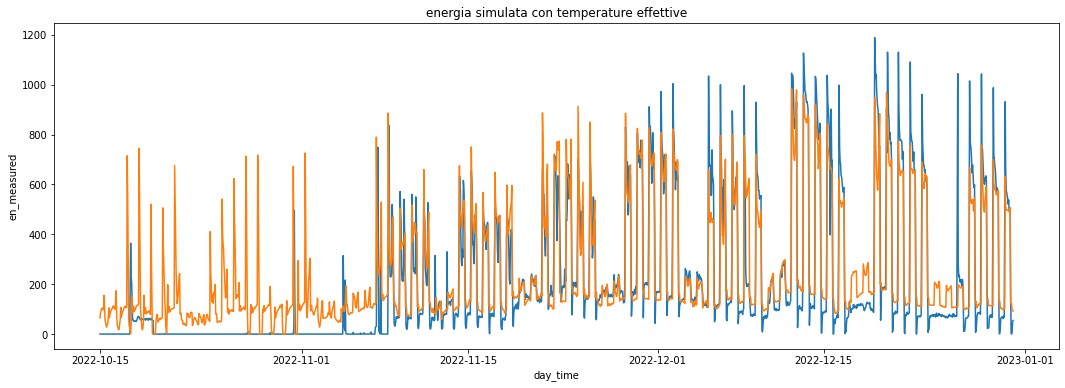

In [333]:
plt.figure( figsize = (18,6))
plt.title("energia simulata con temperature effettive")
sns.lineplot(data = sim_cal1, x = "day_time", y = "en_measured")
sns.lineplot(data = sim_cal1, x = "day_time", y = "en_sim_t_meas")



### Energia simulata con temperatura simlata

In [334]:

colsr = ["ensim"+ str(i) for i in range(1,nsim+1)]
simulations = pd.DataFrame(columns = colsr)

nsim = 150
for s in range(0,nsim):
    opm = sim_cal.op_mode 
    id_sim = 'sim' + str(s+1)
    temperature = tempinv_sim[id_sim].head(4368)
    x = simulate_energy(modello, opm, temperature)
    simulations.loc[:, colsr[s]] = x
    
simulations.insert(0,'daytime', sim_cal.day_time)
simulations.set_index('daytime', inplace = True)
#simulations

In [335]:
sim_cal1['en_sim_t_sim'] =  simulations.head(1848).mean(axis = 1).round(3).values
sim_cal1['err1'] = (sim_cal1.en_measured - sim_cal1.en_sim_t_meas) 
sim_cal1['err2'] = (sim_cal1.en_measured - sim_cal1.en_sim_t_sim) 


In [336]:
sim_cal1.err1.mean(), sim_cal1.err2.mean()

(-30.267786693722933, -46.98322348484848)

In [337]:
sim_cal1.to_csv("sim_cal_1.csv")

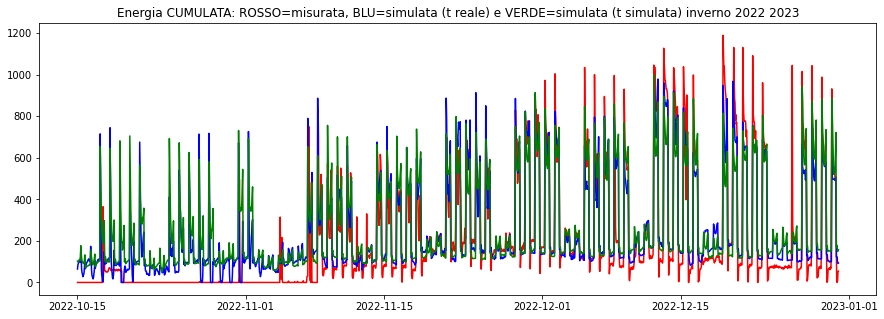

In [338]:
rosso = sim_cal1.loc[ : , ["day_time", "en_measured"  ] ].set_index("day_time")
blu   = sim_cal1.loc[ : , ["day_time", "en_sim_t_meas"] ].set_index("day_time")
verde = sim_cal1.loc[ : , ["day_time", "en_sim_t_sim" ] ].set_index("day_time")

plt.figure(figsize = (15,5))
plt.title("Energia CUMULATA: ROSSO=misurata, BLU=simulata (t reale) e VERDE=simulata (t simulata) inverno 2022 2023")
plt.plot ( rosso, c = 'red',  alpha = 1)
plt.plot ( blu  , c = 'blue',  alpha = 1)
plt.plot ( verde, c = 'green',  alpha = 1)


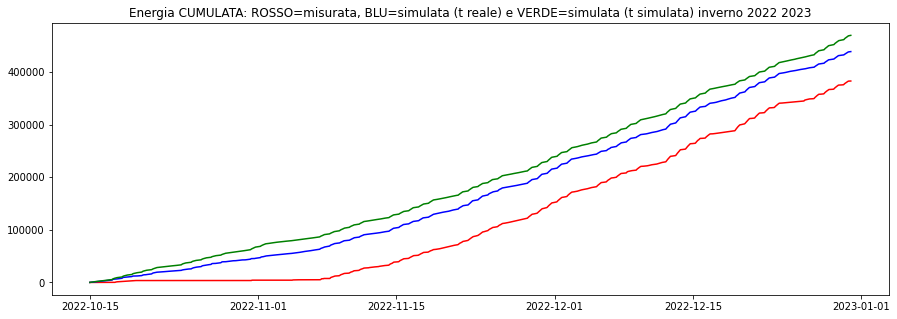

In [339]:
rosso = sim_cal1.loc[ : , ["day_time", "en_measured"  ] ].set_index("day_time").cumsum()
blu   = sim_cal1.loc[ : , ["day_time", "en_sim_t_meas"] ].set_index("day_time").cumsum()
verde = sim_cal1.loc[ : , ["day_time", "en_sim_t_sim" ] ].set_index("day_time").cumsum()

plt.figure(figsize = (15,5))
plt.title("Energia CUMULATA: ROSSO=misurata, BLU=simulata (t reale) e VERDE=simulata (t simulata) inverno 2022 2023")
plt.plot ( rosso, c = 'red',  alpha = 1)
plt.plot ( blu  , c = 'blue',  alpha = 1)
plt.plot ( verde, c = 'green',  alpha = 1)

 


108940.0 104787.0 110772.0
0.961878098035616
1.0168165962915365


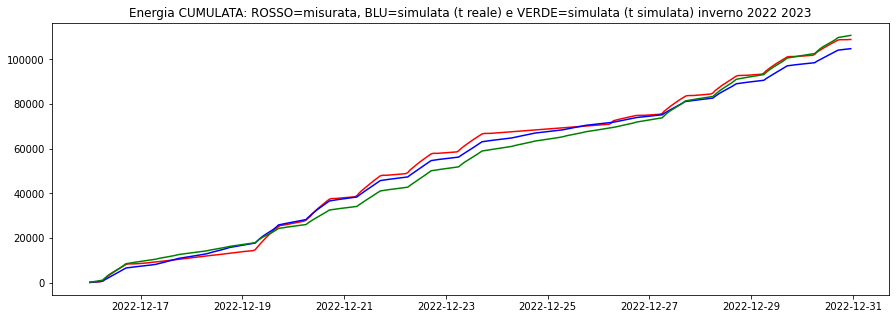

In [340]:
start = 62
end = start+90

rosso = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_measured"  ] ].set_index("day_time").cumsum()
blu   = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_meas"] ].set_index("day_time").cumsum()
verde = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_sim" ] ].set_index("day_time").cumsum()

plt.figure(figsize = (15,5))
plt.title("Energia CUMULATA: ROSSO=misurata, BLU=simulata (t reale) e VERDE=simulata (t simulata) inverno 2022 2023")
plt.plot ( rosso, c = 'red',  alpha = 1)
plt.plot ( blu  , c = 'blue',  alpha = 1)
plt.plot ( verde, c = 'green',  alpha = 1)

tot_rosso = rosso.tail(1).values[0,0].round()
tot_blu =   blu.tail(1).values[0,0].round()
tot_verde = verde.tail(1).values[0,0].round()
print(tot_rosso, tot_blu, tot_verde)
print(tot_blu/tot_rosso) 
print(tot_verde/tot_rosso) 



382995.0 437010.0 467348.0
1.1410331727568246
1.2202456951135132


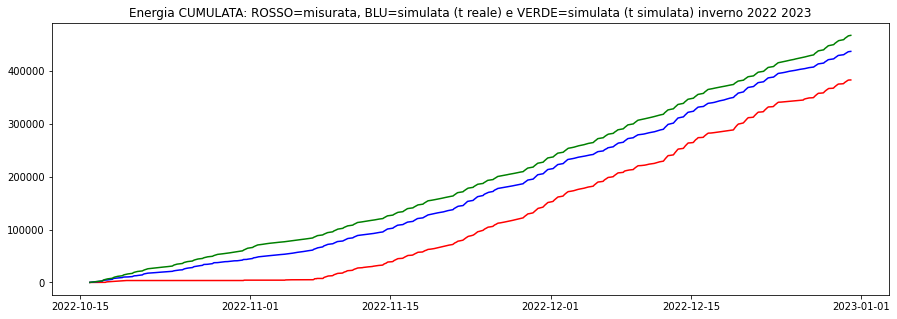

In [341]:
start = 1
end = start+180

rosso = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_measured"  ] ].set_index("day_time").cumsum()
blu   = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_meas"] ].set_index("day_time").cumsum()
verde = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_sim" ] ].set_index("day_time").cumsum()

plt.figure(figsize = (15,5))
plt.title("Energia CUMULATA: ROSSO=misurata, BLU=simulata (t reale) e VERDE=simulata (t simulata) inverno 2022 2023")
plt.plot ( rosso, c = 'red',  alpha = 1)
plt.plot ( blu  , c = 'blue',  alpha = 1)
plt.plot ( verde, c = 'green',  alpha = 1)

tot_rosso = rosso.tail(1).values[0,0].round()
tot_blu =   blu.tail(1).values[0,0].round()
tot_verde = verde.tail(1).values[0,0].round()
print(tot_rosso, tot_blu, tot_verde)
print(tot_blu/tot_rosso) 
print(tot_verde/tot_rosso) 

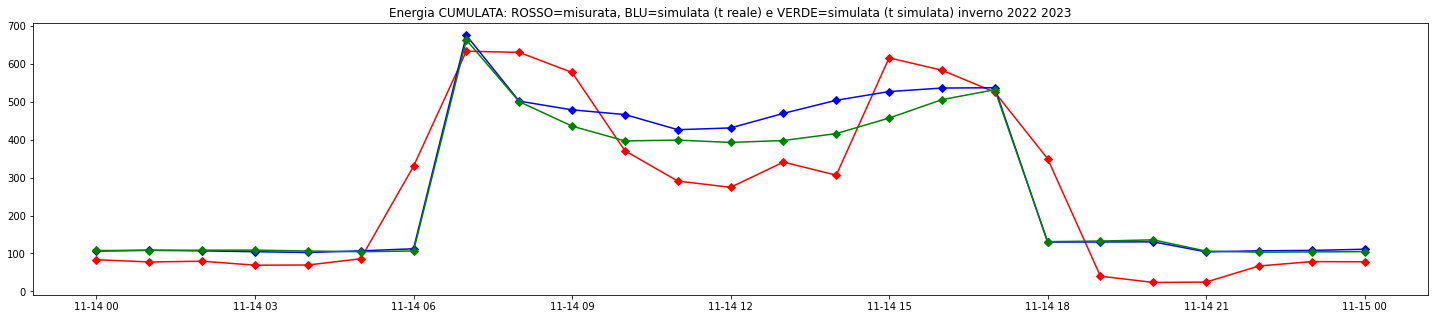

In [343]:
start = 30
end = start+1

rosso = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_measured"  ] ].set_index("day_time") 
blu   = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_meas"] ].set_index("day_time") 
verde = sim_cal1.loc[ start*24:end*24 , ["day_time", "en_sim_t_sim" ] ].set_index("day_time") 

plt.figure(figsize = (25,5))
plt.title("Energia CUMULATA: ROSSO=misurata, BLU=simulata (t reale) e VERDE=simulata (t simulata) inverno 2022 2023")
plt.plot ( rosso, c = 'red',    alpha = 1, marker = "D")
plt.plot ( blu  , c = 'blue',   alpha = 1, marker = "D")
plt.plot ( verde, c = 'green',  alpha = 1, marker = "D")

tende a sottostimare: manca il picco di consumo dell'accensione

# aggiornamento
rendere più semplice l'aggiornamento dei modelli:
scarico settimanale (o giornaliero) delle musure di temperatura e consumo
aggiorno i 4 coefficienti di regressione